In [143]:
from PIL import Image
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import HDBSCAN
import seaborn as sns
import re

from skimage import io, color, filters, measure, morphology

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop

from tqdm import tqdm


Found 520 images


100%|██████████| 520/520 [01:14<00:00,  7.01it/s]


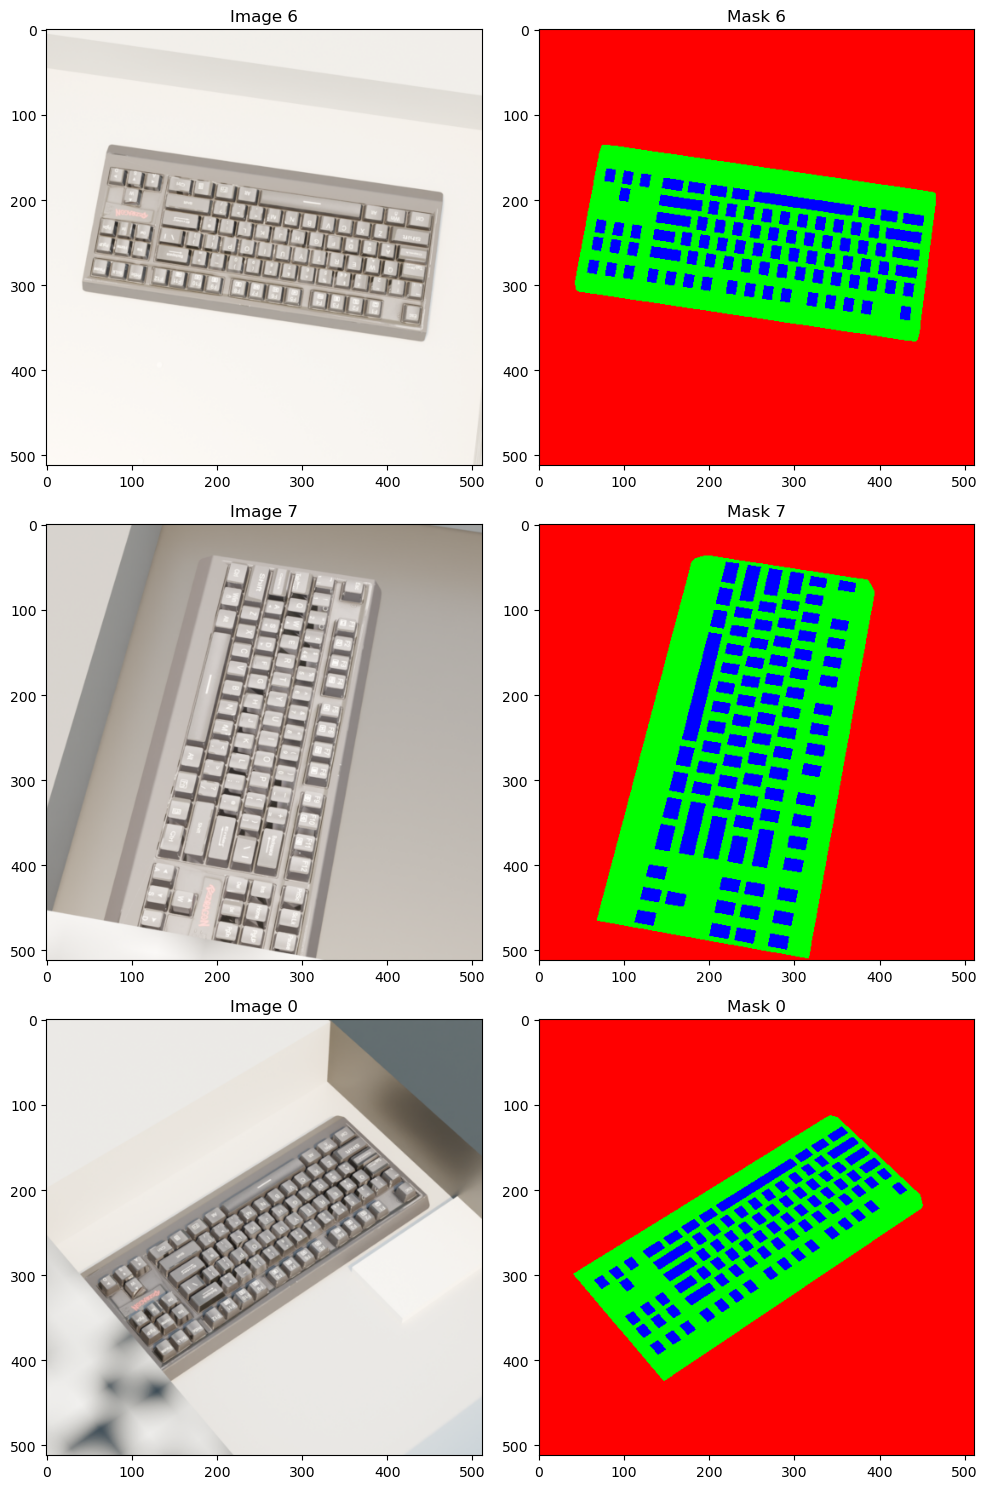

In [144]:
device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
IMG_SIZE = 512
img_dir = "../data_generation/data/data_0/only_keys_detection"

def mask_to_closest_one_hot(mask, unique_values):
    mask_array = np.array(mask, dtype=np.float32)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    mask_tensor = torch.tensor(mask_array).unsqueeze(0)  # Shape: (1, IMAGE_SIZE, IMAGE_SIZE)
    unique_tensor = torch.tensor(unique_values, dtype=torch.float32).view(-1, 1, 1)  # Shape: (3, 1, 1)
    distances = torch.abs(mask_tensor - unique_tensor)  # Shape: (3, IMAGE_SIZE, IMAGE_SIZE)
    closest_indices = torch.argmin(distances, dim=0)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    one_hot = torch.nn.functional.one_hot(closest_indices, num_classes=len(unique_values))  # Shape: (IMAGE_SIZE, IMAGE_SIZE, 3)
    one_hot = one_hot.permute(2, 0, 1).float()

    return one_hot


class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        all_images = os.listdir(root_dir)
        self.images = [img for img in all_images if re.search("Image", img)]
        print(f"Found {len(self.images)} images")
        self.items = []
        loop = tqdm(self.images)
        for img_path in loop:
            image =  Image.open(os.path.join(self.root_dir, img_path)).convert("RGB")
            mask = Image.open(os.path.join(self.root_dir, self._get_mask_for_image(img_path))).convert("L")
            unique_values = np.unique(mask)
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
            transform2 = Compose([ToTensor()])
            mask = mask_to_closest_one_hot(mask, unique_values)
            
            image = transform2(image)
            self.items.append((image, mask))


    def __len__(self):
        return len(self.images)

    def _get_mask_for_image(self, img):
        return img.replace("Image", "Segmentation")

    def __getitem__(self, idx):
        return self.items[idx]
    
transforms = Compose([
    CenterCrop(1080),
    Resize((IMG_SIZE, IMG_SIZE)),
])

def get_images(image_dir, transform = None, batch_size = 1, shuffle = True, pin_memory = True):
    dataset = ImageDataset(image_dir, transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_loader, test_loader

train_loader, test_loader = get_images(img_dir, transforms, batch_size=8)

ig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i, (img, mask) in enumerate(train_loader):
    indices = np.random.choice(img.size(0), 3, replace=False)
    for j, idx in enumerate(indices):
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')
        axes[j, 1].imshow(mask[idx].permute(1, 2, 0))
        axes[j, 1].set_title(f'Mask {idx}')
    break

plt.tight_layout()
plt.show()


15611


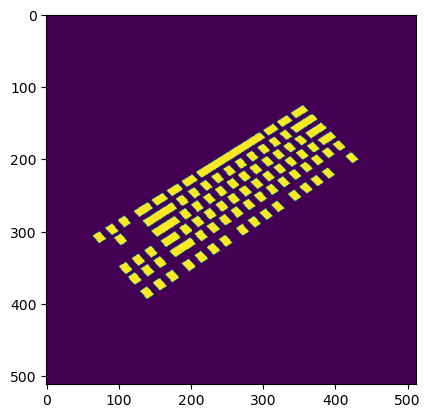

In [145]:
keys = mask[0][2,:].numpy().astype(np.uint8)
plt.imshow(keys)
print(np.sum(keys > 0))

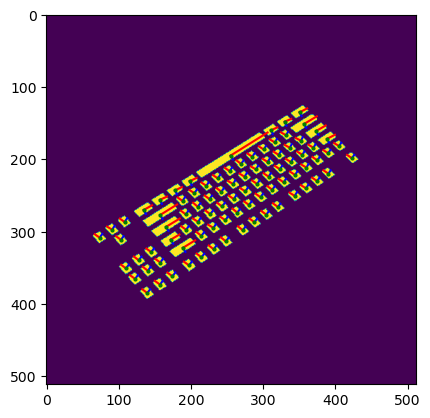

In [146]:
label = measure.label(keys.astype(bool))
regions = measure.regionprops(label)

fig, ax = plt.subplots()
ax.imshow(keys)

centroids = []
for props in regions:
    y0, x0 = props.centroid
    centroids.append(np.array((x0,y0)))
    orientation = props.orientation
    x1 = x0 + np.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - np.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - np.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - np.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=1.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
    ax.plot(x0, y0, '.g', markersize=4)
    
plt.show()

# Assume that we see all the keys

1. Find new base

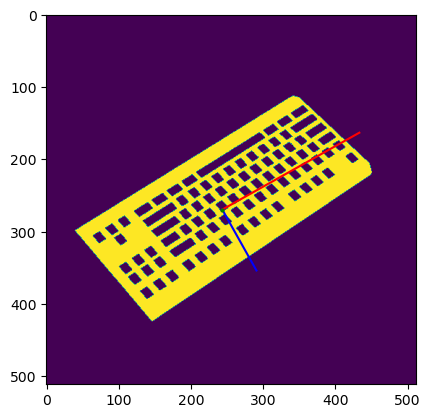

In [147]:
keyboard = mask[0][1,:].numpy().astype(np.uint8)
label = measure.label(keyboard.astype(bool))
regions = measure.regionprops(label)

fig, ax = plt.subplots()
ax.imshow(keyboard)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + np.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - np.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - np.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - np.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=1.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
    ax.plot(x0, y0, '.g', markersize=4)

plt.show()

(139.26470588235293, 385.1411764705882) (73.35031847133757, 308.4012738853503) (422.8550724637681, 198.35507246376812)
[(65.91438741101535, 76.73990258523793), (-283.5903665814152, 186.7861040068201)]
[array([1, 0]), array([0, 1])] [array([65.91438741, 76.73990259]), array([-283.59036658,  186.78610401])]


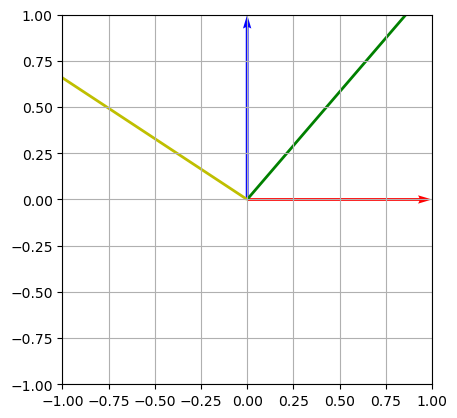

In [148]:
centroids =np.array(centroids)

x_coords = np.array(centroids[:,0]).flatten()
y_coords = np.array(centroids[:,1]).flatten()

y0, x0 = y_coords[np.argmax(y_coords)], x_coords[np.argmax(y_coords)]
y1, x1 = y_coords[np.argmin(x_coords)], x_coords[np.argmin(x_coords)]
y2, x2 = y_coords[np.argmax(x_coords)], x_coords[np.argmax(x_coords)]

print((x0,y0), (x1,y1), (x2, y2))

base1 = [(1,0),(0,1)]
base2 = [ (x0 - x1, y0-y1), (x0-x2, y0-y2)]
print(base2)

base1 = [np.array(vec) for vec in base1]
base2 = [np.array(vec) for vec in base2]
base2 = [vec for vec in base2]
print(base1, base2)

fig, ax = plt.subplots()
origin = np.array([[0, 0], [0, 0]])

ax.quiver(*origin, [vec[0] for vec in base1], [vec[1] for vec in base1], color=['r', 'b'], scale=1, scale_units='xy', angles='xy')

ax.quiver(*origin, [vec[0] for vec in base2], [vec[1] for vec in base2], color=['g', 'y'], scale=1, scale_units='xy', angles='xy')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
plt.grid()
plt.show()

In [149]:
M_base1_base2 = np.matrix(base2).T

centroids2 = np.matrix(centroids).T

centroids_base2 = np.matmul(np.linalg.inv(M_base1_base2), centroids2)

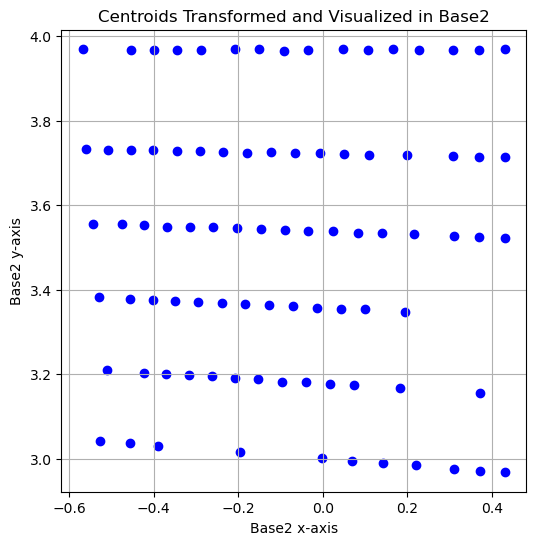

In [150]:
y_coords = np.array(centroids_base2[0, :]).flatten()
x_coords = np.array(centroids_base2[1, :]).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', label='Centroids in Base2')
plt.title('Centroids Transformed and Visualized in Base2')
plt.xlabel('Base2 x-axis')
plt.ylabel('Base2 y-axis')
plt.grid(True)
plt.axis('equal')
plt.show()

# Lets put this together

In [250]:
def get_centroids(keys):
    label = measure.label(keys.astype(bool))
    regions = measure.regionprops(label)

    space_area = 0
    space_coords = None
    centroids = []
    for i, props in enumerate(regions):
        y0, x0 = props.centroid
        centroids.append(np.array((x0,y0)))

        if props.area > space_area:
            space_area = props.area
            space_coords = i

    return np.array(centroids) if len(centroids) >= 87 else np.array([np.array((0,0))]), space_coords

def get_bases(centroids):
    x_coords = np.array(centroids[:,0]).flatten()
    y_coords = np.array(centroids[:,1]).flatten()

    y0, x0 = y_coords[np.argmax(y_coords)], x_coords[np.argmax(y_coords)]
    y1, x1 = y_coords[np.argmin(x_coords)], x_coords[np.argmin(x_coords)]
    y2, x2 = y_coords[np.argmax(x_coords)], x_coords[np.argmax(x_coords)]

    print((x0,y0), (x1,y1), (x2, y2))

    base1 = [(1,0),(0,1)]
    base2 = [(x0-x2, y0-y2), (x0-x1, y0-y1)]

    base2 = sorted(base2, key= lambda v : np.linalg.norm(v), reverse=True)

    if min([np.linalg.norm(v) for v in base2]) < 1e-6: 
        print("Singular")
        return base1, base1 #error handling

    base1 = [np.array(vec) for vec in base1]
    base2 = [np.array(vec) for vec in base2]
    base2 = [vec for vec in base2]

    return base1, base2

def get_coords(mask):
    keys = mask[2,:].numpy().astype(np.uint8)
    keyboard = mask[1,:].numpy().astype(np.uint8)
    
    centroids, space_coords = get_centroids(keys)
    base1, base2 = get_bases(centroids)

    M_base1_base2 = np.matrix(base2).T

    print(M_base1_base2)
    
    centroids2 = np.matrix(centroids).T
    centroids_base2 = np.matmul(np.linalg.inv(M_base1_base2), centroids2)

    return centroids, centroids_base2, space_coords

In [277]:
keyboard_layout = [
    ["Esc", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12", "PrtScr", "ScrLck", "Pause"],
    ["`~", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "Backspace", "Insert", "Home", "PageUp"],
    ["Tab", "Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P", "[", "]", "\\", "Delete", "End", "PageDown"],
    ["Caps Lock", "A", "S", "D", "F", "G", "H", "J", "K", "L", ";", "'", "Enter"],
    ["Shift1", "Z", "X", "C", "V", "B", "N", "M", ",", ".", "/", "Shift", "↑"],
    ["Ctrl1", "Win1", "Alt1", "Spacebar", "Alt", "Win", "Menu", "Ctrl", "←", "↓", "→"],
    #["Insert", "Home", "Page Up", "Delete", "End", "Page Down", "↑", "←", "↓", "→"]
]

(382.4161073825503, 370.71812080536915) (91.4608695652174, 232.05217391304348) (425.6413793103448, 284.3103448275862)
[[290.95523782 -43.22527193]
 [138.66594689  86.40777598]]
Space: 0.35233335034313573 0.0013527307051400062
           0         1  rows  rows_sorted
0   0.007528  0.965167     0            0
1   0.126159  0.970324     0            0
3   0.182156  0.971902     0            0
5   0.238312  0.973855     0            0
8   0.294674  0.974349     0            0
13  0.377389  0.977226     0            0
15  0.434361  0.979926     0            0
21  0.491783  0.982304     0            0
25  0.548852  0.984893     0            0
31  0.630057  0.987028     0            0
38  0.687901  0.988406     0            0
43  0.746357  0.990392     0            0
48  0.804540  0.991771     0            0
56  0.882480  0.994937     0            0
61  0.940976  0.996806     0            0
65  0.999995  1.000000     0            0
(65.11160714285714, 359.04017857142856) (26.270833333333332,

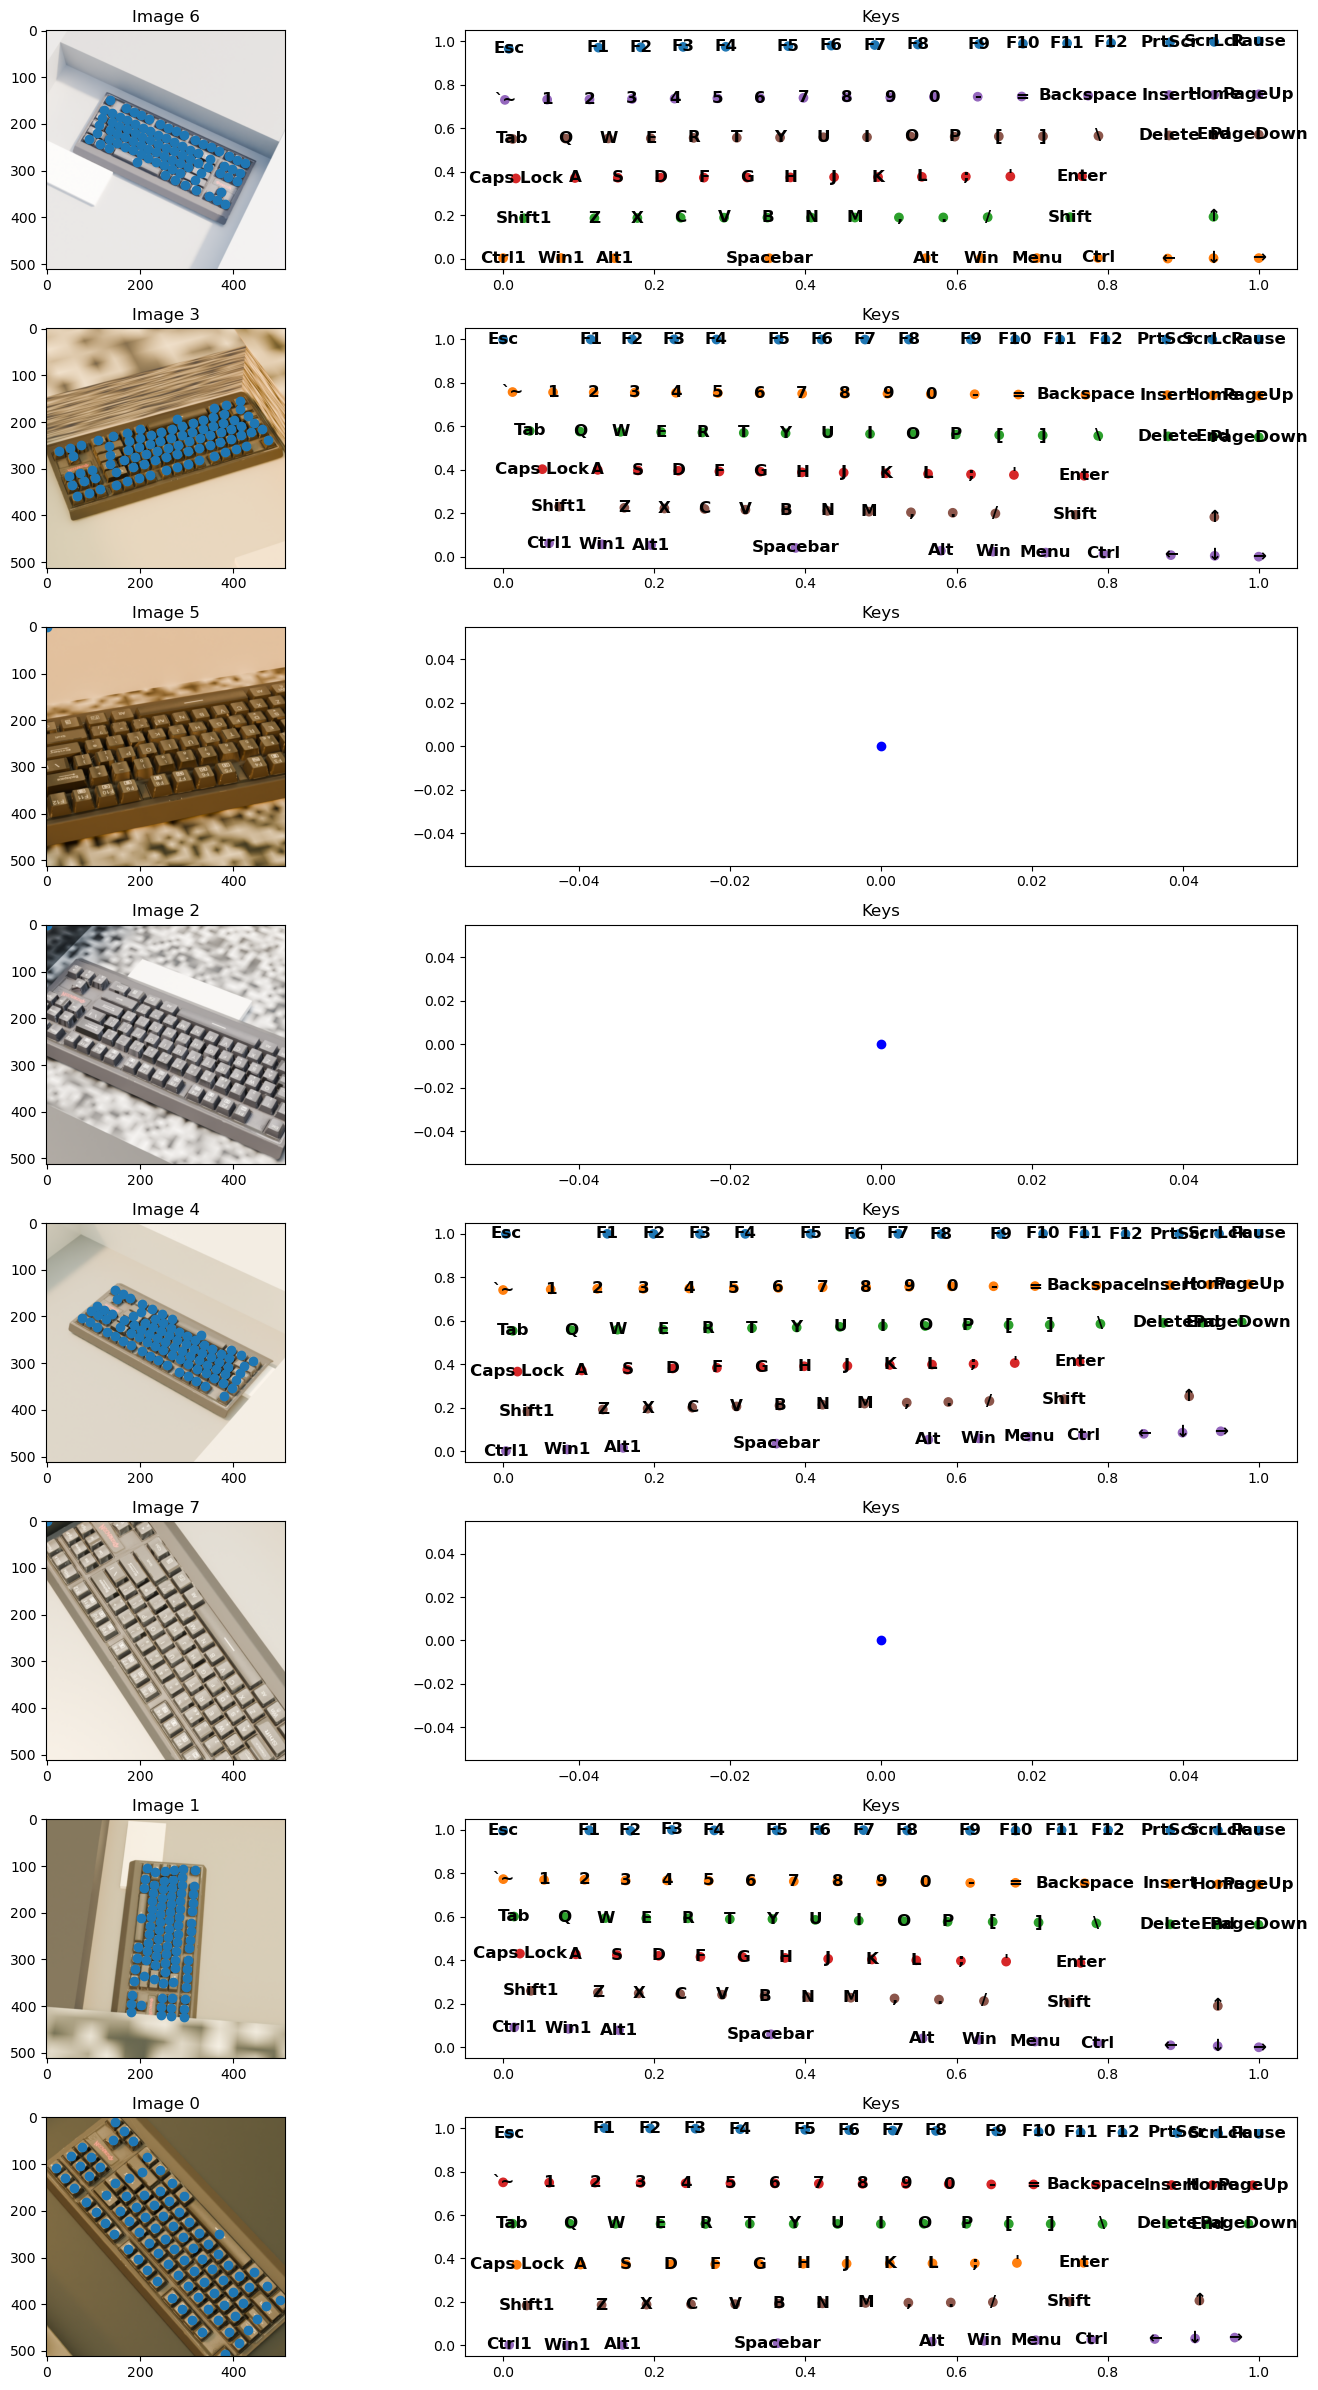

In [283]:
ig, axes = plt.subplots(8, 2, figsize=(16, 24))

for i, (img, mask) in enumerate(train_loader):
    indices = np.random.choice(img.size(0), 8, replace=False)
    for j, idx in enumerate(indices):
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')

        keys, centroids, space_coords = get_coords(mask[idx])
        x_coords = -np.array(centroids[0, :]).flatten()
        y_coords = -np.array(centroids[1, :]).flatten()

        colors = None
        X = None
        symbols = None
        x_values = None
        y_values = None

        if len(x_coords) > 1:
            
            x_coords = (x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))
            y_coords = (y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))

            if space_coords is not None:
                space_x = x_coords[space_coords]
                space_y = y_coords[space_coords]
                
                if space_x > 0.5:
                    x_coords = -x_coords
                    x_coords = (x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))
                if space_y > 0.5:
                    y_coords = -y_coords
                    y_coords = (y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))

                space_x = x_coords[space_coords]
                space_y = y_coords[space_coords]
                print("Space:", space_x, space_y)

            X = pd.DataFrame({"0": x_coords, "1":y_coords})
            X["1"] = X["1"]*10000

            m = HDBSCAN(min_cluster_size=6, )
            m.fit(X)

            labels = m.labels_

            unique_labels = np.unique(labels)
            palette = sns.color_palette('tab10', n_colors=len(unique_labels))
            palette.append((0.5, 0.5, 0.5))

            colors = [palette[label] if label >= 0 else palette[-1] for label in labels]

            X["rows"] = labels

            mean_values = X.groupby("rows")["1"].mean()
            sorted_classes = mean_values.sort_values(ascending=False).index
            class_mapping = {old: new for new, old in enumerate(sorted_classes)}
            X["rows_sorted"] = X["rows"].map(class_mapping)
            X["1"] = X["1"]/10000
            print(X[X["rows_sorted"] == 0])

            if len(unique_labels) == 6:
                letters_dict = {}
                for row_number in X["rows_sorted"].unique():
                    row = X[X["rows_sorted"] == row_number]
                    row = row.sort_values(by="0", ascending=True)
                        
                    for key, (_, center) in enumerate(row.iterrows()):
                        letters_dict[keyboard_layout[row_number][key]] = center[["0", "1"]].values.tolist()

                symbols = list(letters_dict.keys())
                values = list(letters_dict.values())

                x_values = [val[0] for val in values]
                y_values = [val[1] for val in values]

        axes[j,0].scatter(keys[:, 0].flatten(), keys[:, 1].flatten())
        
        axes[j, 1].scatter(x_coords, y_coords, 
                           color='blue' if colors is None else colors, 
                           label='Centroids in Base2')
        axes[j, 1].set_title(f'Keys')

        if symbols is not None:
            for i, key in enumerate(symbols):
               axes[j, 1].text(x_values[i], y_values[i], key, ha='center', va='center', fontweight='bold', fontsize=12)

    break

plt.tight_layout()
plt.show()